In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from pylab import *
import struct
import array
import os
from scipy.interpolate import griddata

# Athena++ modules
# import athena_read
import athena_read_select
import athena_read
import h5py
import netCDF4
import xarray as xr
import scipy as sp

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
filename = 'disk.out1.00100.athdf'

In [3]:
q = 0.9e-3
Rh = (q/3) ** (1/3)

In [4]:
Rh

0.06694329500821695

In [32]:
planet_pos = np.array([1.0, np.pi/2, np.pi])
_p_phi, _p_z, _p_r = np.linspace(0, 2*np.pi, 64), np.linspace(0, 0.04, 32), np.linspace(0, 0.04, 64)

p_phi, p_z, p_r = np.meshgrid(_p_phi, _p_z, _p_r, indexing='ij')

g_r = np.sqrt((planet_pos[0] + p_r * np.cos(p_phi))**2 + (p_r * np.sin(p_phi))**2)
g_phi = np.arctan2(p_r * np.sin(p_phi), planet_pos[0] + p_r * np.cos(p_phi)) + planet_pos[2]
g_theta = np.arctan2(p_z, g_r) + planet_pos[1]

xi = np.vstack([g_phi.flatten(), g_theta.flatten(), g_r.flatten()]).T # the list of points we will use to interpolate data

In [45]:
ds_raw = athena_read.athdf(filename, raw=True, quantities=['rho', 'vel1', 'vel2', 'vel3'], )

level = 4
sel_mb_lev = np.where(ds_raw['Levels'] == level)[0]
logi_locs = ds_raw['LogicalLocations'][sel_mb_lev]
logi_locs -= logi_locs.min(axis=0)
Nx_mb = ds_raw['MeshBlockSize']
Nx_lev = Nx_mb * (logi_locs.max(axis=0) + 1)  # b/c locs starts from 0
# cc means cell center
ccr, cctheta, ccphi = np.zeros(Nx_lev[0], dtype=np.float32), np.zeros(Nx_lev[1], dtype=np.float32), np.zeros(Nx_lev[2], dtype=np.float32)
rho_lev4 = np.zeros(Nx_lev[::-1], dtype=np.float32)
vel1_lev4 = np.zeros(Nx_lev[::-1], dtype=np.float32)
vel2_lev4 = np.zeros(Nx_lev[::-1], dtype=np.float32)
vel3_lev4 = np.zeros(Nx_lev[::-1], dtype=np.float32)

for idx_sel_mb, idx_mb in enumerate(sel_mb_lev):
    #print(idx_sel_mb, idx_mb)
    _ccr, _cctheta, _ccphi = ds_raw['x1v'][idx_mb], ds_raw['x2v'][idx_mb], ds_raw['x3v'][idx_mb]
    ccr[Nx_mb[0]*logi_locs[idx_sel_mb][0]:Nx_mb[0]*(logi_locs[idx_sel_mb][0]+1)] = _ccr
    cctheta[Nx_mb[1]*logi_locs[idx_sel_mb][1]:Nx_mb[1]*(logi_locs[idx_sel_mb][1]+1)] = _cctheta
    ccphi[Nx_mb[2]*logi_locs[idx_sel_mb][2]:Nx_mb[2]*(logi_locs[idx_sel_mb][2]+1)] = _ccphi
    
    rho_lev4[Nx_mb[2]*logi_locs[idx_sel_mb][2]:Nx_mb[2]*(logi_locs[idx_sel_mb][2]+1), 
             Nx_mb[1]*logi_locs[idx_sel_mb][1]:Nx_mb[1]*(logi_locs[idx_sel_mb][1]+1),
             Nx_mb[0]*logi_locs[idx_sel_mb][0]:Nx_mb[0]*(logi_locs[idx_sel_mb][0]+1)] = ds_raw['rho'][idx_mb]
    
    vel1_lev4[Nx_mb[2]*logi_locs[idx_sel_mb][2]:Nx_mb[2]*(logi_locs[idx_sel_mb][2]+1), 
              Nx_mb[1]*logi_locs[idx_sel_mb][1]:Nx_mb[1]*(logi_locs[idx_sel_mb][1]+1),
              Nx_mb[0]*logi_locs[idx_sel_mb][0]:Nx_mb[0]*(logi_locs[idx_sel_mb][0]+1)] = ds_raw['vel1'][idx_mb]
    
    vel2_lev4[Nx_mb[2]*logi_locs[idx_sel_mb][2]:Nx_mb[2]*(logi_locs[idx_sel_mb][2]+1), 
              Nx_mb[1]*logi_locs[idx_sel_mb][1]:Nx_mb[1]*(logi_locs[idx_sel_mb][1]+1),
              Nx_mb[0]*logi_locs[idx_sel_mb][0]:Nx_mb[0]*(logi_locs[idx_sel_mb][0]+1)] = ds_raw['vel2'][idx_mb]
    
    vel3_lev4[Nx_mb[2]*logi_locs[idx_sel_mb][2]:Nx_mb[2]*(logi_locs[idx_sel_mb][2]+1), 
              Nx_mb[1]*logi_locs[idx_sel_mb][1]:Nx_mb[1]*(logi_locs[idx_sel_mb][1]+1),
              Nx_mb[0]*logi_locs[idx_sel_mb][0]:Nx_mb[0]*(logi_locs[idx_sel_mb][0]+1)] = ds_raw['vel3'][idx_mb]

ValueError: zero-size array to reduction operation minimum which has no identity

In [48]:
ds_raw = athena_read.athdf(filename, raw=True, quantities=['rho', ], )

block_size = ds_raw['MeshBlockSize']
root_grid_size = ds_raw['RootGridSize']
levels = ds_raw['Levels'][:]
logical_locations = ds_raw['LogicalLocations'][:]

lev = 3  # find the boundaries of level 3 and read in the data using the bounding box
idx_to_merge = np.argwhere(levels==lev).ravel()
bounding_box = np.array([[ds_raw['x1v'][idx_to_merge].min(), ds_raw['x1v'][idx_to_merge].max()], 
                         [ds_raw['x2v'][idx_to_merge].min(), ds_raw['x2v'][idx_to_merge].max()], 
                         [ds_raw['x3v'][idx_to_merge].min(), ds_raw['x3v'][idx_to_merge].max()], 
                        ])
# now use level 4 to set the finest resolution, the official script will automatically cast data
ds = athena_read.athdf(filename, level=4, 
                fast_restrict=True, quantities=['rho', ], 
                x1_min=bounding_box[0][0], x1_max=bounding_box[0][1], x2_min=bounding_box[1][0], x2_max=bounding_box[1][1], x3_min=bounding_box[2][0], x3_max=bounding_box[2][1], )

In [40]:
diff_dim1 = cctheta[1:] - cctheta[:-1]
diff_dim1.size, diff_dim1[diff_dim1<0].size   # no negative differences!

(287, 0)

In [41]:
ccphi.shape

(192,)

In [42]:
interp_rho_generator = sp.interpolate.RegularGridInterpolator((ccphi, cctheta, ccr), rho_lev4) # assuming it is Cartesian enough
interp_rho = interp_rho_generator(xi).reshape([64, 32, 64])

In [43]:
interp_vel1_generator = sp.interpolate.RegularGridInterpolator((ccphi, cctheta, ccr), vel1_lev4) # assuming it is Cartesian enough
interp_vel1 = interp_vel1_generator(xi).reshape([64, 32, 64])

interp_vel2_generator = sp.interpolate.RegularGridInterpolator((ccphi, cctheta, ccr), vel2_lev4) # assuming it is Cartesian enough
interp_vel2 = interp_vel2_generator(xi).reshape([64, 32, 64])

interp_vel3_generator = sp.interpolate.RegularGridInterpolator((ccphi, cctheta, ccr), vel3_lev4) # assuming it is Cartesian enough
interp_vel3 = interp_vel3_generator(xi).reshape([64, 32, 64])

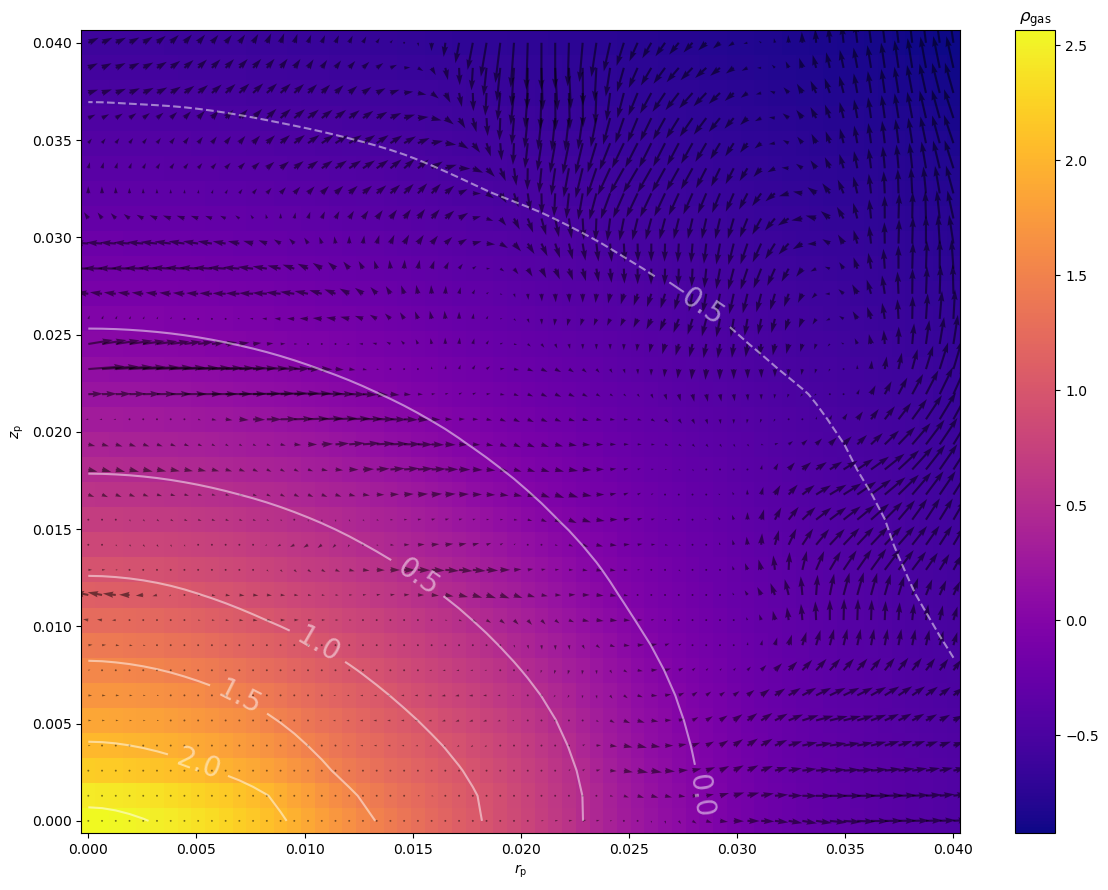

In [44]:
fig, ax = plt.subplots(figsize=(12, 9))

im = ax.pcolormesh(_p_r, _p_z, np.log10(interp_rho.mean(axis=0)), shading='nearest', cmap='plasma')
cax = fig.colorbar(im)
cax.ax.set_title(r"$\rho_{\rm gas}$")

CS = ax.contour(_p_r, _p_z, np.log10(interp_rho.mean(axis=0)), 6, colors='w', alpha=0.5)
ax.clabel(CS, fontsize=20, inline=True)

ax.quiver(_p_r, _p_z, interp_vel1.mean(axis=0), interp_vel2.mean(axis=0), color=(0, 0, 0, 0.5))

ax.set(xlabel=r"$r_{\rm p}$", ylabel=r"$z_{\rm p}$")
fig.tight_layout()

In [130]:
rp = 1

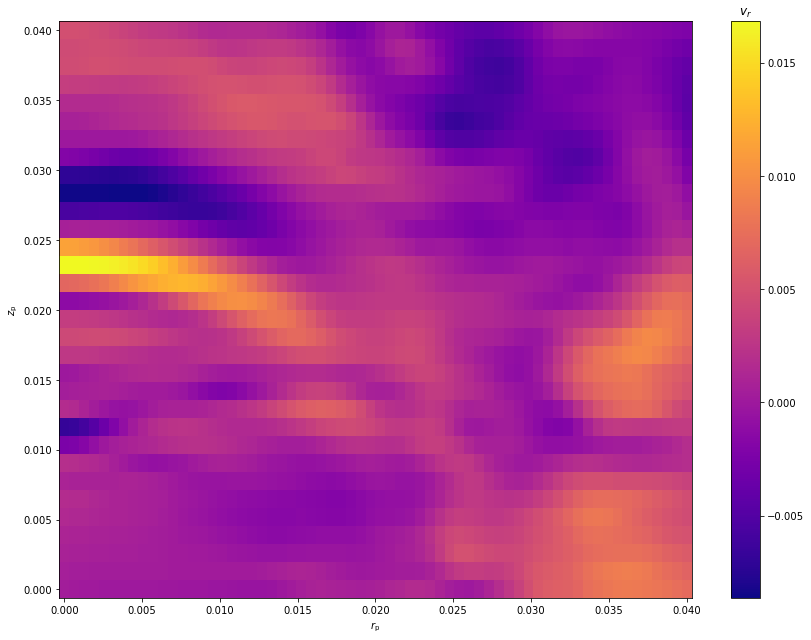

In [133]:
fig, ax = plt.subplots(figsize=(12, 9))

im = ax.pcolormesh(_p_r, _p_z, interp_vel1.mean(axis=0), shading='nearest', cmap='plasma')
cax = fig.colorbar(im)
cax.ax.set_title(r"$v_r$")

# CS = ax.contour(_p_r, _p_z, interp_vr.mean(axis=0), 6, colors='w', alpha=0.5)
# ax.clabel(CS, fontsize=20, inline=True)

# ax.quiver(_p_r, _p_z, interp_vr.mean(axis=0), interp_vel2.mean(axis=0), color=(0, 0, 0, 0.5))

ax.set(xlabel=r"$r_{\rm p}$", ylabel=r"$z_{\rm p}$")
fig.tight_layout()